# Final Project for DTSA-5509

Kevin Juandi <br> 2023-10-09 <br> https://github.com/Chiuchiyin/Heartbeat-ECG-Classification

## Introduction and Problem Description

Welcome to my final project for DTSA-5509! Before running this notebook, please ensure you have all required dependancies installed in your build. All required packages are listed in the next section. If you want to run the code, some parts of the code might take very long time to run, especially Gradient Boost model. Please be patient with it. Thank you for reviewing my project

I previously worked in heart ultrasound imaging as a student and is currently looking for opportunities to work in health informatics. With that in mind, I looked for a related topic to my previous background and stumbled upon this dataset on [Kaggle](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)<sup>[1]</sup>. The dataset itself is a compilation of two famous datasets in heartbeat classification, the [MIT-BIH Arrhythmia Dataset](https://www.physionet.org/content/mitdb/1.0.0/)<sup>[2]</sup> and the [PTB Diagnostic ECG Database](https://www.physionet.org/content/ptbdb/1.0.0/)<sup>[3]</sup>. The dataset is unfortunately too large to be included in the repo. Please scroll down to see the citations in requested format.

The purpose of this project is to train models with classification algorithm in attempt to predict various types of cardiac arrhythmias based on ECG Data. This could potentially save lives.

An ECG (Electrocardiogram) is a medical test that records the electrical signals in the heart. It's a common and painless test used to quickly detect heart problems and monitor the heart's health.<sup>[4]</sup> A healthy individual's heartbeat on an ECG is characterized by a distinctive waveform, representing normal functioning of the heart. When the heart is not functioning optimally, the ECG could detect distortions in the anticipated waveform, severe and life-threatening arrhythmias might present a different or nonexistent waveform altogether.

This project attempts to use machine learning techniques to classify ECG data as either healthy or as one of four different kinds of arrhythmia.

Each observation in the dataset represents a single heartbeat on an ECG and is sampled at 125 Hz with 187 total points per observation (~1.5 seconds per observation). These time series points serve as the features of our dataset. Many of these heartbeats are padded with zeros at the end if they lasted for less than 1.5 seconds. Each observation is classified into one of five categories: 
- 0 = Non-ectopic (Normal) 
- 1 = Supra Ventricular Ectopic (S) 
- 2 = Ventricular Ectopic (V)
- 3 = Fusion (F)
- 4 = Unclassifiable (Q)

Without further ado, let us begin working

## Loading dependancies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, precision_score, recall_score, accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
%matplotlib inline

## Helper functions

To reduce clutter, we use these functions

In [45]:
def train_model(model, X_train, y_train, cv_type, name, **cv_kwargs):
    """Trains a machine learning model using the provided training data and cross validation search type.
    The best model is saved to file with the given name. If that file already exists, this function simply loads it"""
    file_name = f"./{name}.pkl"
    
    if os.path.isfile(file_name):
        model = joblib.load(file_name)
    else:
        if cv_type == "grid":
            model = GridSearchCV(model, **cv_kwargs)
        else:
            model = RandomizedSearchCV(model, **cv_kwargs)
        
        model.fit(X_train, y_train)

        joblib.dump(model, file_name)
    
    print("Best Model Parameters")
    print(model.best_params_)
    
    return model

def make_confusion_matrix(model, X, y):
    """Display the confusion matrix of a model's predictions of given data. Also display Macro F1 Score."""
    
    yhat = model.predict(X)
    
    f1 = f1_score(y, yhat, average="macro")
    print(f"Macro F1 Score = {f1}")
    
    cm = ConfusionMatrixDisplay(confusion_matrix(y, yhat))
    cm.plot()
    
def add_to_model_summary_df(summary_df, model, model_name, X_test, y_test):
    """Compiles the results of many machine learning models into a single dataframe for easy analysis"""
    if summary_df is None:
        summary_df = pd.DataFrame(columns=["Name", "Accuracy", "Precision", "Recall", "Macro F1", "Train Time"])
        
    y_test_pred = model.predict(X_test)
    
    model_summary_dict = {"Name": [model_name],
                          "Accuracy": [accuracy_score(y_test, y_test_pred)],
                          "Precision": [precision_score(y_test, y_test_pred, average="macro")],
                          "Recall": [recall_score(y_test, y_test_pred, average="macro")],
                          "Macro F1": [f1_score(y_test, y_test_pred, average="macro")],
                          "Train Time": [np.sum(model.cv_results_["mean_fit_time"])]}
    
    return pd.concat([summary_df, pd.DataFrame(model_summary_dict)], ignore_index=True)

## Load the data

like most dataset on Kaggle, this data is already pre-separated into training and test set. However, column labels aren't provided so we would just label them as their point number in time series

In [3]:
data_file_train = ".\data\mitbih_train.csv"
data_file_test = ".\data\mitbih_test.csv"

column_names = [f"Point {i+1}" for i in range(187)] + ["label"]
df_train = pd.read_csv(data_file_train, names=column_names)
df_test = pd.read_csv(data_file_test, names=column_names)

df_train["label"] = df_train["label"].astype(int)
df_test["label"] = df_test["label"].astype(int)

df_train.head()

,Point 1,Point 2,Point 3,Point 4,Point 5,Point 6,Point 7,Point 8,Point 9,Point 10,...,Point 179,Point 180,Point 181,Point 182,Point 183,Point 184,Point 185,Point 186,Point 187,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
df_train.dtypes.value_counts()

float64    187
int32        1
dtype: int64

This confirms that we have 187 rows of data and an integer output label for each rows. Let us then take a look of the data shape.

In [5]:
print(f"Train Dataframe Shape = {df_train.shape}")
print(f"Test Dataframe Shape = {df_test.shape}")

Train Dataframe Shape = (87554, 188)
Test Dataframe Shape = (21892, 188)


Drop the label column and check if all the points are between 0 and 1

In [6]:
df_train.drop(columns='label')[(0 <= df_train) & (df_train <= 1)].isna().sum().sum()

0

In [7]:
df_test.drop(columns='label')[(0 <= df_test) & (df_test <= 1)].isna().sum().sum()

0

Thus we confirmed that every feature in this dataset is numeric and strictly between 0 and 1. The target variable is a categorical variable encoded as an integer

## Preprocessing

This is a very large dataset and it would be impractical to train a model with my laptop due to the expensive training costs. To tackle this, both the train and test data will be down sampled in order to create a smaller dataset to work with.

Firstly, let us visualize the distribution of different classes in the train and test data.

train_value_counts
test_value_counts


Text(0.5, 1.0, 'Test Data Label Distribution')

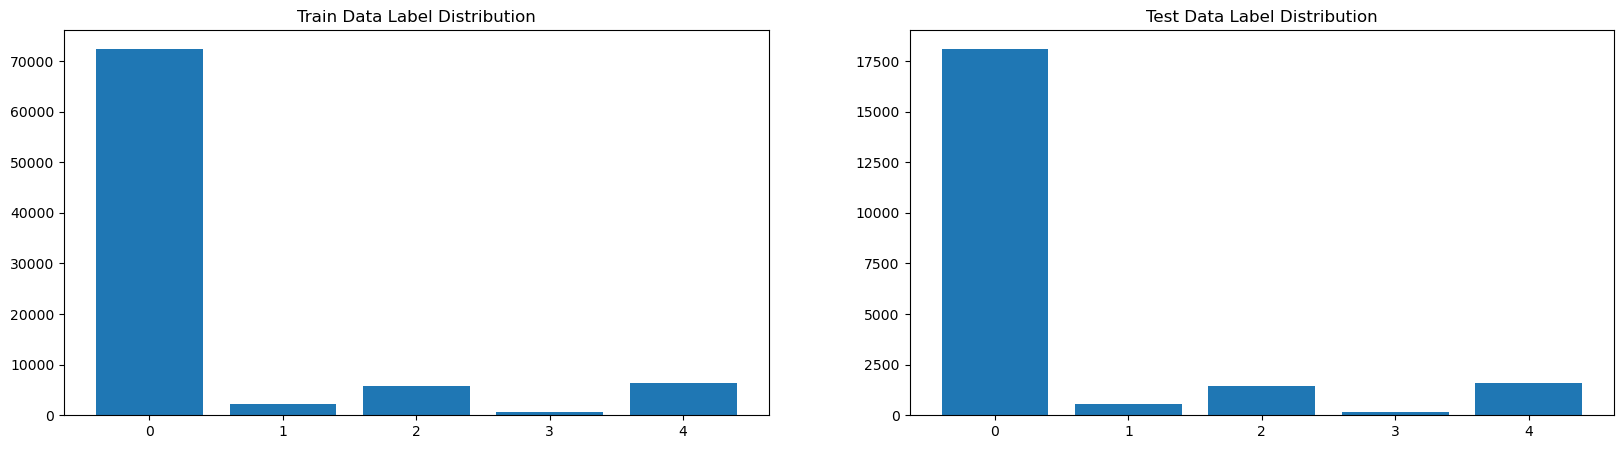

In [8]:
train_value_counts = df_train["label"].value_counts()
test_value_counts = df_test["label"].value_counts()
print("train_value_counts")
print("test_value_counts")
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].bar(train_value_counts.index, train_value_counts.values)
axs[0].set_title("Train Data Label Distribution")
axs[1].bar(test_value_counts.index, test_value_counts.values)
axs[1].set_title("Test Data Label Distribution")

In [9]:
print("Class Proportions")
train_value_counts / np.sum(train_value_counts)

Class Proportions


0    0.827729
4    0.073452
2    0.066108
1    0.025390
3    0.007321
Name: label, dtype: float64

In [10]:
print("Class Proportions")
test_value_counts / np.sum(test_value_counts)

Class Proportions


0    0.827608
4    0.073451
2    0.066143
1    0.025397
3    0.007400
Name: label, dtype: float64

The training set and test set have almost the same distribution.

Our dataset is very imbalanced with almost 83% examples being normal normal heartbeats (category 0) and the rest being various arrhythmias. To deal with this, I'll do two different approaches. One with stratified sampling to down sample the data, which will preserve the distribution of data classes. It can be done using the train_test_split() method from sklearn.  Another approach would be weighted sampling to create balanced dataset which is done similarly.

### Stratified Sampling

In [11]:
downsampling_factor = 0.1

_, df_train_sub = train_test_split(df_train, test_size=downsampling_factor, stratify=df_train["label"], random_state=42)
_, df_test_sub = train_test_split(df_test, test_size=downsampling_factor, stratify=df_test["label"], random_state=42)

print(f"Train Dataframe Shape = {df_train_sub.shape}")
print(f"Test Dataframe Shape = {df_test_sub.shape}")

Train Dataframe Shape = (8756, 188)
Test Dataframe Shape = (2190, 188)


Now let us check the distribution of the down sampled data to make sure that it still resembles the distribution of the original data

Text(0.5, 1.0, 'Test Data Label Distribution')

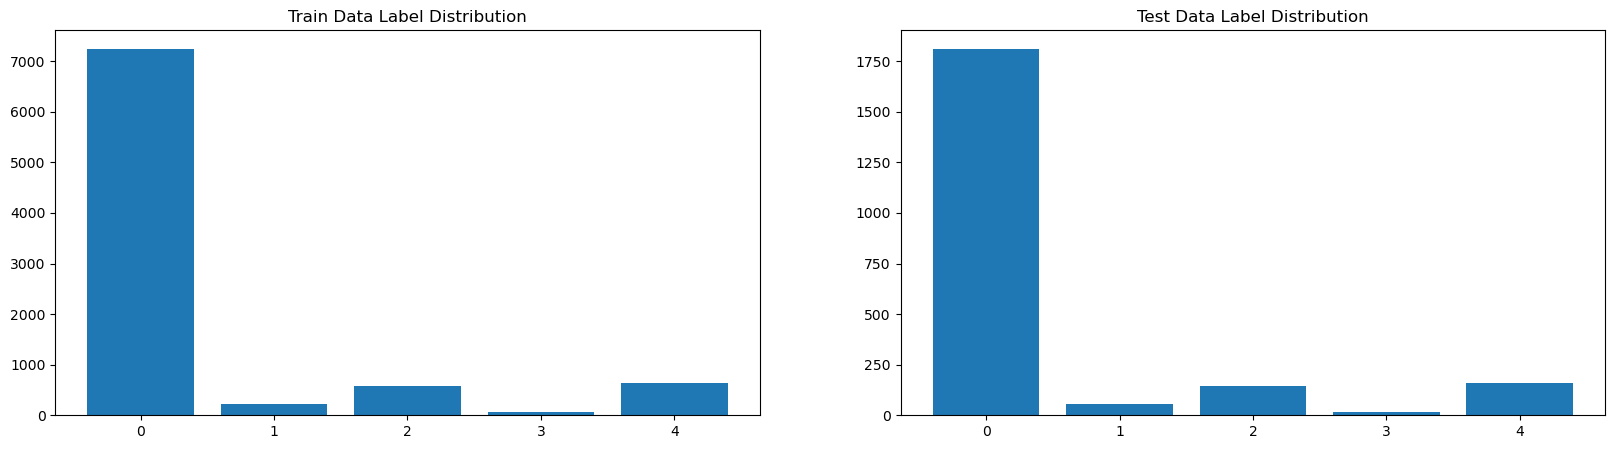

In [12]:
train_sub_value_counts = df_train_sub["label"].value_counts()
test_sub_value_counts = df_test_sub["label"].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].bar(train_sub_value_counts.index, train_sub_value_counts.values)
axs[0].set_title("Train Data Label Distribution")
axs[1].bar(test_sub_value_counts.index, test_sub_value_counts.values)
axs[1].set_title("Test Data Label Distribution")

In [13]:
print("Class Proportions")
train_sub_value_counts / np.sum(train_sub_value_counts)

Class Proportions


0    0.827775
4    0.073435
2    0.066126
1    0.025354
3    0.007309
Name: label, dtype: float64

Yes, we are good. It still has the similar distribution. Next, we confirm if there are no missing values in the data.

In [14]:
print(f"Missing Values in train set: {df_train_sub.isnull().values.any()}")
print(f"Missing Values in test set: {df_test_sub.isnull().values.any()}")

Missing Values in train set: False
Missing Values in test set: False


### Weighted Sampling


In [15]:
df_1=df_train[df_train['label']==1]
df_2=df_train[df_train['label']==2]
df_3=df_train[df_train['label']==3]
df_4=df_train[df_train['label']==4]
df_0=(df_train[df_train['label']==0]).sample(n=2000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=2000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=2000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=2000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=2000,random_state=126)

df_train_balanced=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
df_train_balanced

,Point 1,Point 2,Point 3,Point 4,Point 5,Point 6,Point 7,Point 8,Point 9,Point 10,...,Point 179,Point 180,Point 181,Point 182,Point 183,Point 184,Point 185,Point 186,Point 187,label
10153,0.162791,0.540698,0.755814,0.186047,0.168605,0.546512,0.616279,0.697674,0.651163,0.703488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
33886,0.990066,0.938742,0.344371,0.034768,0.273179,0.331126,0.326159,0.341060,0.347682,0.347682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
32005,0.974239,0.932084,0.590164,0.131148,0.014052,0.168618,0.238876,0.210773,0.196721,0.208431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
56159,0.978495,0.723118,0.526882,0.298387,0.220430,0.158602,0.091398,0.091398,0.080645,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
61783,0.963351,0.709424,0.060209,0.013089,0.057592,0.041885,0.047120,0.034031,0.039267,0.044503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81124,1.000000,0.484848,0.541667,0.526515,0.522727,0.507576,0.496212,0.412879,0.284091,0.140152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
84177,0.787072,0.695817,0.619772,0.600760,0.574144,0.551331,0.520913,0.479087,0.433460,0.311787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
86829,1.000000,0.536585,0.574526,0.525745,0.544715,0.536585,0.539295,0.509485,0.455285,0.455285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
83623,0.839286,1.000000,0.477041,0.272959,0.188776,0.191327,0.193878,0.191327,0.176020,0.168367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


Sanity check to ensure we have the right proportion.

In [16]:
df_train_balanced_value_counts = df_train_balanced["label"].value_counts()
print("Class Proportions")
df_train_balanced_value_counts / np.sum(df_train_balanced_value_counts)

Class Proportions


0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: label, dtype: float64

Let us do the same with the test dataset

In [17]:
df_1=df_test[df_test['label']==1]
df_2=df_test[df_test['label']==2]
df_3=df_test[df_test['label']==3]
df_4=df_test[df_test['label']==4]
df_0=(df_test[df_test['label']==0]).sample(n=400,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=400,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=400,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=400,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=400,random_state=126)

df_test_balanced=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
df_test_balanced

,Point 1,Point 2,Point 3,Point 4,Point 5,Point 6,Point 7,Point 8,Point 9,Point 10,...,Point 179,Point 180,Point 181,Point 182,Point 183,Point 184,Point 185,Point 186,Point 187,label
12631,0.967089,0.686076,0.230380,0.053165,0.083544,0.050633,0.017722,0.037975,0.035443,0.010127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
11106,0.875728,1.000000,0.547573,0.077670,0.015534,0.025243,0.025243,0.033010,0.087379,0.248544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
14259,1.000000,0.884718,0.428954,0.096515,0.080429,0.088472,0.083110,0.064343,0.067024,0.040214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3073,1.000000,0.491935,0.173387,0.245968,0.189516,0.125000,0.116935,0.068548,0.084677,0.052419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5617,1.000000,0.674731,0.080645,0.061828,0.091398,0.088710,0.077957,0.080645,0.069892,0.094086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20945,0.883721,0.733850,0.620155,0.563307,0.591731,0.403101,0.441860,0.341085,0.260982,0.211886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
21860,1.000000,0.451705,0.448864,0.409091,0.403409,0.392045,0.366477,0.338068,0.284091,0.241477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
20389,0.688406,0.410628,0.400966,0.379227,0.340580,0.299517,0.248792,0.212560,0.157005,0.072464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
20631,0.783537,0.675305,0.564024,0.416159,0.263719,0.132622,0.050305,0.015244,0.047256,0.094512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


## EDA
Let us start by visualizing a few examples of each heart beat type.

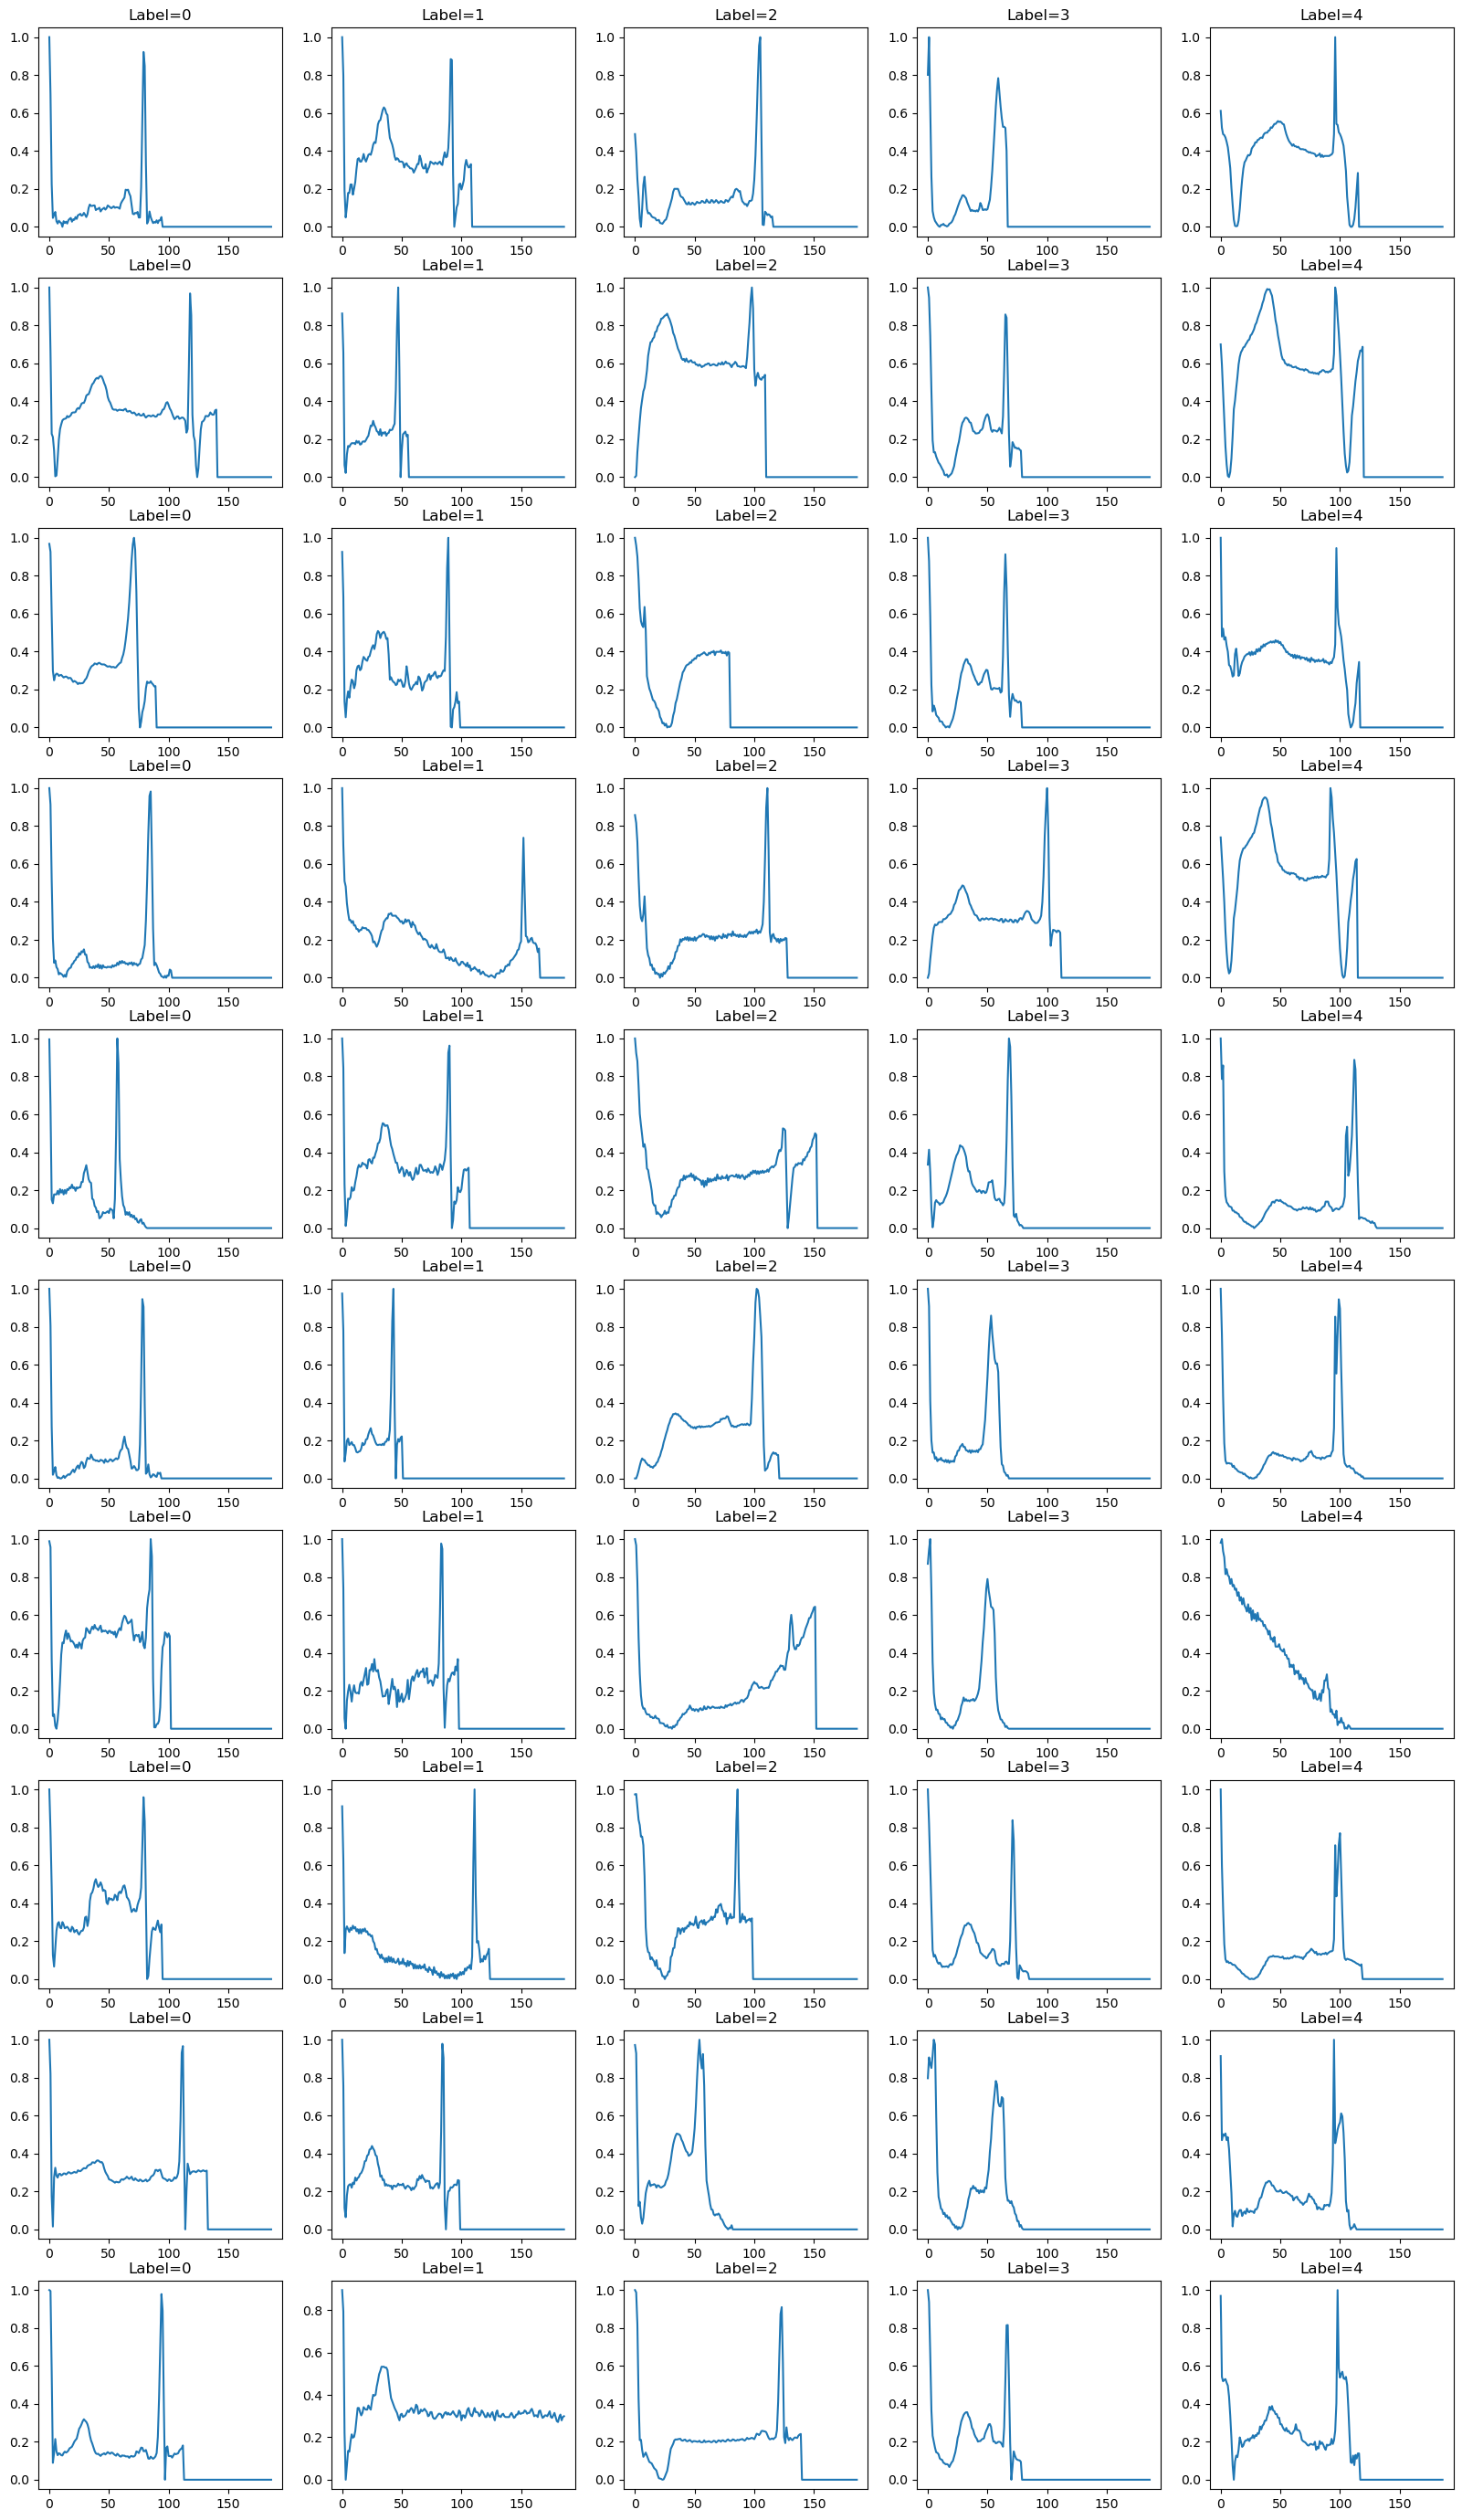

In [18]:
labels = [0, 1, 2, 3, 4]

n_to_view = 10
fig, axs = plt.subplots(n_to_view, 5, figsize=(20, 35))
for label in labels:
    label_df = df_train_sub[df_train_sub["label"] == label]
    for i in range(n_to_view):
        data = label_df.drop(['label'], axis=1).iloc[i].values
        axs[i, label].plot(range(len(data)), data)
        axs[i, label].set_title(f"Label={label}")

We could observe that in these examples, only normal heartbeat (class 0) has consistency in visual appearance. The other classes look rather inconsistent, sometimes completely out of place. Within class 0, every example has the large spike in a different spot. This suggest that it is not a consistent feature to examine. Almost every example is also zero padded at the end, meaning that the later features in the time series are unlikely to be as relevant as the early features.

In order to introduce some summary statistics of the waveform into the datasets, the mean and standard deviation of each time series will be added as additional features.

In [19]:
train_means = df_train_sub.drop(['label'], axis=1).mean(axis=1)
train_stds = df_train_sub.drop(['label'], axis=1).std(axis=1)
df_train_sub["mean"] = train_means
df_train_sub["std"] = train_stds

test_means = df_test_sub.drop(['label'], axis=1).mean(axis=1)
test_stds = df_test_sub.drop(['label'], axis=1).std(axis=1)
df_test_sub["mean"] = test_means
df_test_sub["std"] = test_stds

In [20]:
train_balanced_means = df_train_balanced.drop(['label'], axis=1).mean(axis=1)
train_balanced_stds = df_train_balanced.drop(['label'], axis=1).std(axis=1)
test_balanced_means = df_test_balanced.drop(['label'], axis=1).mean(axis=1)
test_balanced_stds = df_test_balanced.drop(['label'], axis=1).std(axis=1)

df_train_balanced["mean"] = train_balanced_means
df_train_balanced["std"] = train_balanced_stds
df_test_balanced["mean"] = test_balanced_means
df_test_balanced["std"] = test_balanced_stds

Let us take a look at the correlation matrix. This might provide us some interesting insight

<AxesSubplot:>

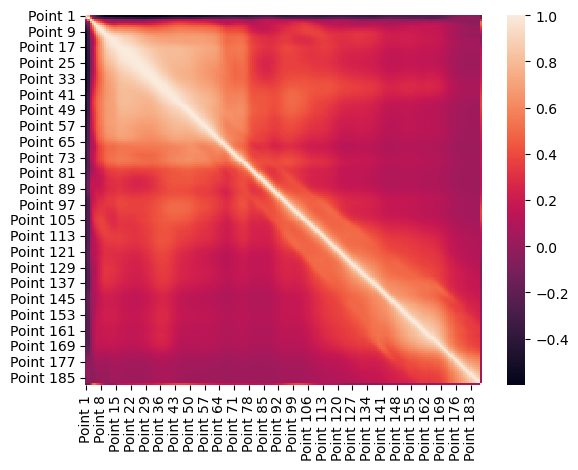

In [21]:
sns.heatmap(df_train.corr())

The large number of features in this dataset make it hard to perform any feature selection decisions based on this correlation matrix. However there are still some interesting observations to be made from this correlation matrix heat map.

-   Approximately the first 30% of the dataset shows a high level of correlation between features, suggesting the presence of significant features in this segment of the ECG. This may also be due to the absence of zero-padding at this stage.
-   In the later points of the dataset, where zero-padding is more prevalent, there is little to no correlation between features.
-   The correlation between neighboring points is notably high, which is expected given that these points represent a discrete sampling of a continuous waveform.

We would then move on to outlier detection and eventually remove them.

To visualize outliers, a simple approach will be used. We first generate a scatter plot to visualize the relationship between the mean and the standard deviation of all examples in the training set

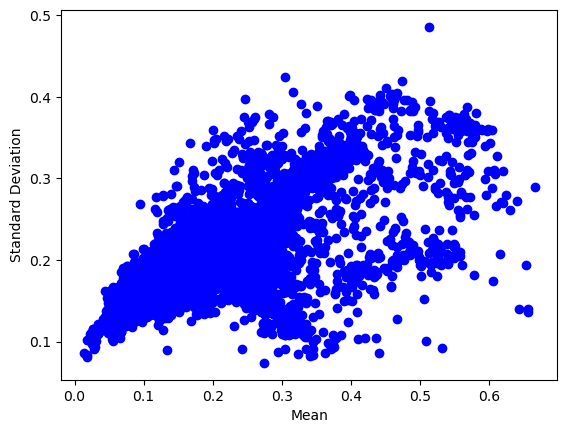

In [22]:
plt.scatter(df_train_sub["mean"], df_train_sub["std"], c="blue")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.show()

A majority of the points in this dataset lie within one large cluster in the mean/standard deviation space but there are some outliers. In order to algorithmically find these outliers, the DBSCAN clustering algorithm is used, which is a clustering algorithm with a concept points that don't fit into any cluster. Any point that is not part of the main cluster will be considered an outlier.

Note: The hyper-parameters of the DBSCAN algorithm eps and min_samples were chosen manually through trial and error

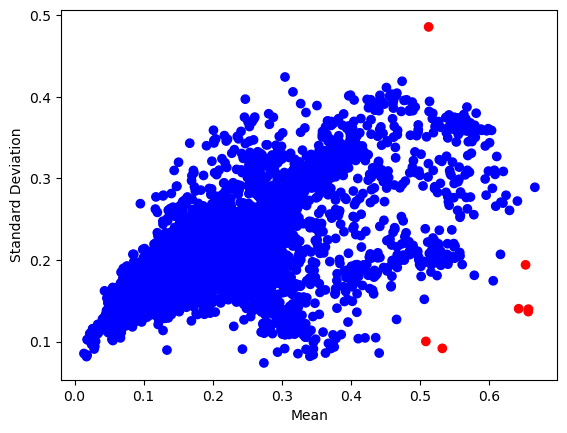

In [23]:
dbs = DBSCAN(eps=0.05, min_samples=10).fit(df_train_sub[["mean", "std"]])
dbs.labels_

colors = []
for label in dbs.labels_:
    if label == -1:
        colors.append("red")
    else:
        colors.append("blue")

plt.scatter(df_train_sub["mean"], df_train_sub["std"], c=colors)
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.show()

Now we visualize the ECG waves of these outliers:

In [24]:
outlier_df = df_train_sub.iloc[np.where(dbs.labels_ == -1)[0]]

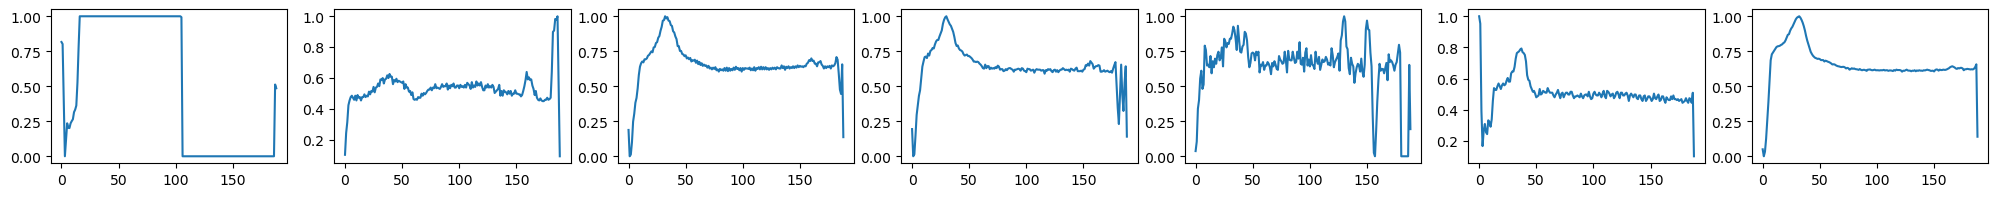

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=len(outlier_df), figsize=(25, 2))
for i, data in enumerate(outlier_df.drop(["label"], axis=1).values):
    axs[i].plot(range(len(data)), data)
plt.show()

The only one of these outliers appears to be odd and unnatural ECG waveform, which is the first one. A possible reason to explain why the rest are outliers is that they have very little padded zeros at the end and so their means are higher while their standard deviations are lower. Therefore, only the first outlier above will be removed from the dataset

In [26]:
df_train_sub = df_train_sub.drop([outlier_df.iloc[0].name], axis=0)

In [27]:
df_train_sub.shape

(8755, 190)

## Feature Selection

Our data has a lot of features, one way to perform feature selection on a dataset is using Random Forest algorithm. Once a random forest is trained an estimation of the feature importances can be extracted.

First fit a random forest classifier to the training data. It is important to search over a wide range of hyper parameter choices but it is computationally intensive to do so, so a random search over the hyper parameters will be used rather than a grid search.

In cases like this one where the dataset is highly unbalanced, classification accuracy may not be an appropriate evaluation metric for the model. Instead, the Macro F1 score is recommended, which provides the mean F1 score across all individual classes, and will be utilized for this model and all subsequent models.

First we convert the train and test dataframes into numpy arrays.

In [28]:
X_train = df_train_sub.drop(['label'], axis=1).values
X_test = df_test_sub.drop(['label'], axis=1).values
y_train = df_train_sub["label"].values
y_test = df_test_sub["label"].values

In [29]:
rf_parameters = dict(n_estimators = [10*i for i in range(1, 11)],
                     max_depth = [2**i for i in range(11)]+[None],
                     min_samples_split = [i+1 for i in range(1, 10)],
                     min_samples_leaf = [i for i in range(1, 10)])
scorer = make_scorer(f1_score, average="macro")

rf_feature_select = train_model(RandomForestClassifier(random_state=42),
                                X_train, y_train, "random", "rf_feature_select", 
                                param_distributions=rf_parameters, n_jobs=8, scoring=scorer, 
                                verbose=1, n_iter=100, random_state=42)                                 

Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 32}


In [30]:
rf_feature_select.best_params_

{'n_estimators': 80,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 32}

Macro F1 Score = 0.819340734981622


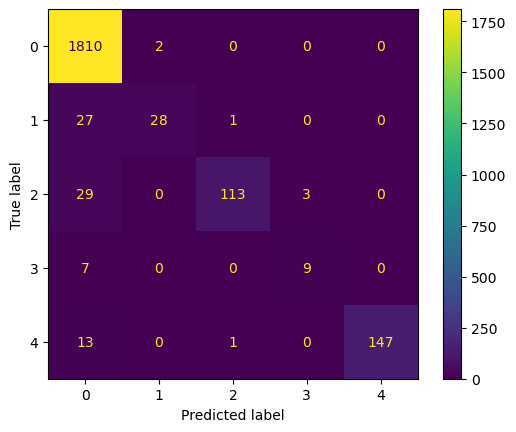

In [31]:
make_confusion_matrix(rf_feature_select, X_test, y_test)

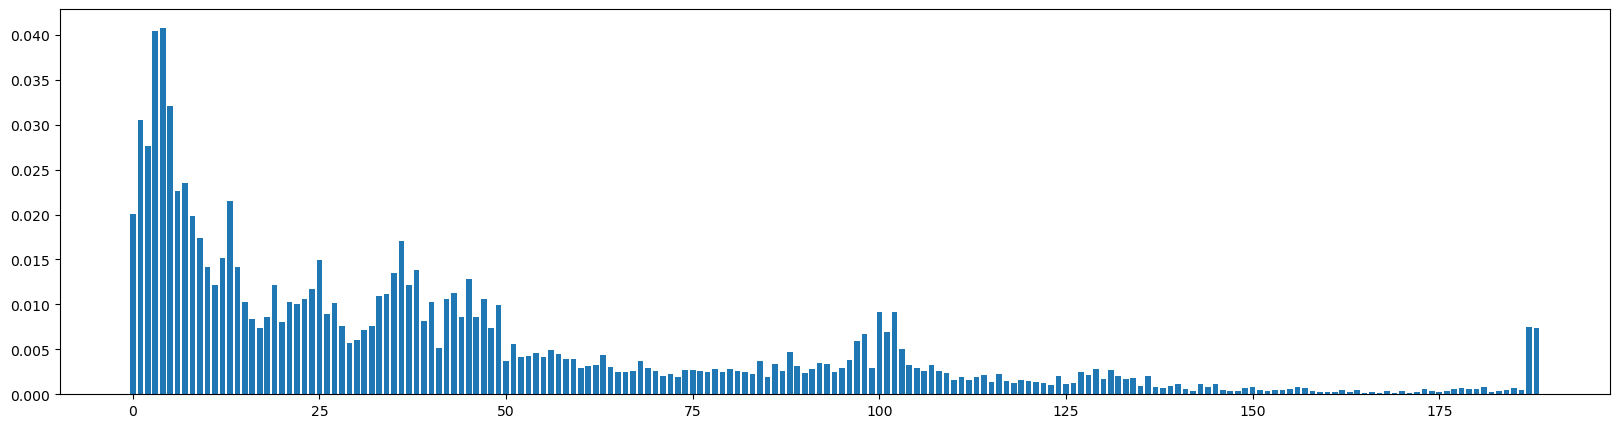

In [32]:
feature_importances = rf_feature_select.best_estimator_.feature_importances_
feature_names = np.array(column_names, dtype=object)

plt.figure(figsize=(20, 5))
plt.bar([i for i in range(len(feature_importances))], feature_importances, width=0.75)
plt.show()

The early points in this dataset are much more significant features than the later points. In general, the feature importance seems to roughly decays towards 0 as you move along the ECG waveform. The later features are mostly padded zeros, which explains their low significance. The mean and standard deviation features added above (the last two points) are also moderately significant.

In order to filter out some of the less significant features, all features with a significance of > 0.005 will be considered insignificant. Later analysis will compare if this feature selection helps or hinders the model fitting.

In [33]:
feature_mask = feature_importances > 0.005
X_train_filtered = X_train[:, feature_mask]
X_test_filtered = X_test[:, feature_mask]

print(f"Filtered Train Shape: {X_train_filtered.shape}")
print(f"Filtered Test Shape: {X_test_filtered.shape}")

Filtered Train Shape: (8755, 59)
Filtered Test Shape: (2190, 59)


In [34]:
X_train_balanced = df_train_balanced.drop(['label'], axis=1).values
y_train_balanced = df_train_balanced["label"].values
X_test_balanced = df_test_balanced.drop(['label'], axis=1).values
y_test_balanced = df_test_balanced["label"].values

X_train_balanced_filtered = X_train_balanced[:, feature_mask]
X_test_balanced_filtered = X_test_balanced[:, feature_mask]

With this, we have eliminated a large amount of features

## Building the Models

We would first train the model with imbalanced dataset and then with balanced one.
### KNN

Let us start with the simplest model which is K-Nearest Neighbors (KNN) model to the full unfiltered training dataset, using 5-fold cross validation to search over a range of values for K using the macro F1 score as the evaluation metric.

In [35]:
knn_parameters = dict(n_neighbors=[i for i in range(1, 10)])

knn_full = train_model(KNeighborsClassifier(),
                       X_train, y_train, "grid", "knn_full",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(None, knn_full, "knn_full", X_test, y_test)

Best Model Parameters
{'n_neighbors': 3}


Macro F1 Score = 0.7984347919904761


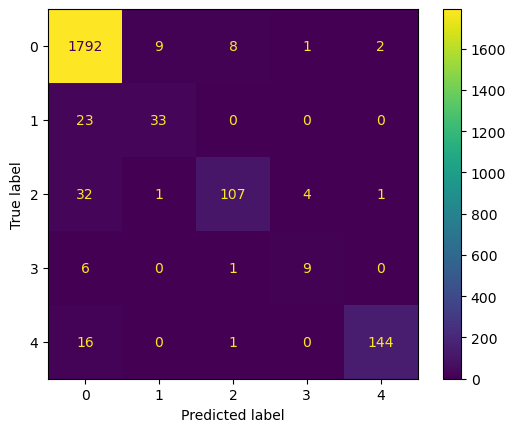

In [47]:
make_confusion_matrix(knn_full, X_test, y_test)

Now we perform the same procedure to fit a KNN model to the training dataset filtered with the feature importance threshold.

In [37]:
knn_filtered = train_model(KNeighborsClassifier(),
                           X_train_filtered, y_train, "grid", "knn_filtered",
                           param_grid=knn_parameters, scoring=scorer)
model_summary_df = add_to_model_summary_df(model_summary_df, knn_filtered, "knn_filtered", X_test_filtered, y_test)

Best Model Parameters
{'n_neighbors': 1}


Macro F1 Score = 0.8412712529800273


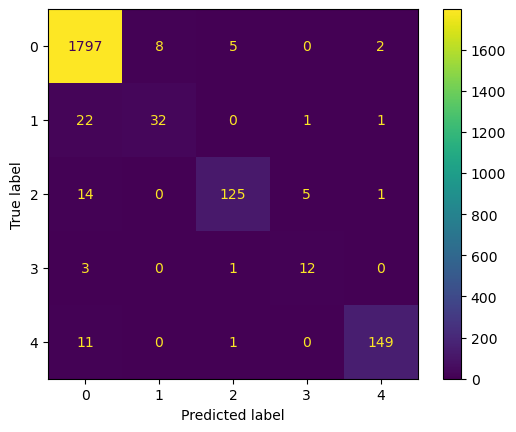

In [49]:
make_confusion_matrix(knn_filtered, X_test_filtered, y_test)

Now, for balanced dataset

In [39]:
knn_balanced = train_model(KNeighborsClassifier(),
                       X_train_balanced, y_train_balanced, "grid", "knn_balanced",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(model_summary_df, knn_balanced, "knn_balanced", X_test_balanced, y_test_balanced)

Best Model Parameters
{'n_neighbors': 1}


Macro F1 Score = 0.8714263004082656


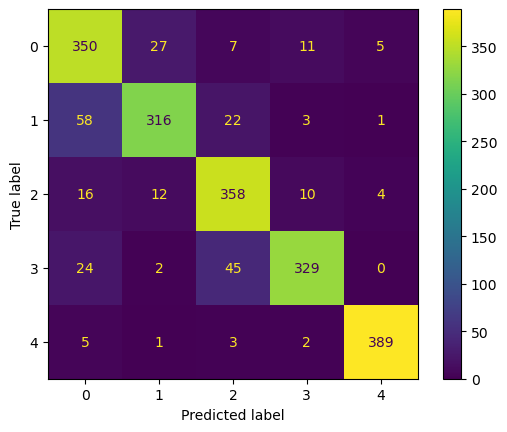

In [48]:
make_confusion_matrix(knn_balanced, X_test_balanced, y_test_balanced)

with features filtered

In [50]:
knn_balanced_filtered = train_model(KNeighborsClassifier(),
                       X_train_balanced_filtered, y_train_balanced, "grid", "knn_balanced_filtered",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(model_summary_df, knn_balanced_filtered, 
                                           "knn_balanced_filtered", X_test_balanced_filtered, y_test_balanced)

Best Model Parameters
{'n_neighbors': 1}


Macro F1 Score = 0.879820383954647


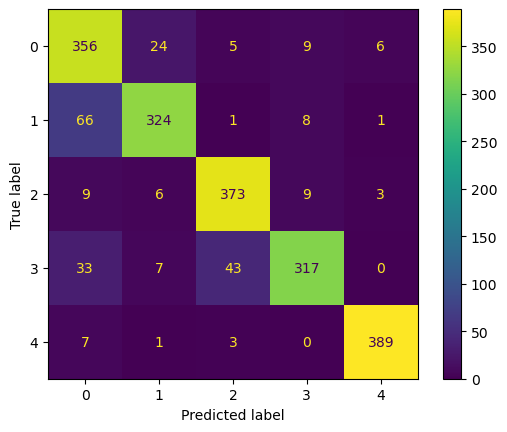

In [51]:
make_confusion_matrix(knn_balanced_filtered, X_test_balanced_filtered, y_test_balanced)

### Random Forest
We would now fit a random forest model to the full features, doing the same random search with 5-fold cross validation over the parameters that was used when fitting the random forest used for feature importance above.

In [53]:
rf_full = train_model(RandomForestClassifier(random_state=42),
                      X_train, y_train, "random", "rf_full",
                      param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_full, "rf_full", X_test, y_test)

Best Model Parameters
{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 1024}


Macro F1 Score = 0.8028023996272614


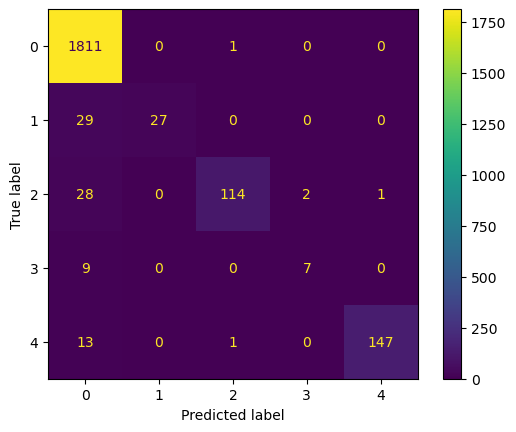

In [54]:
make_confusion_matrix(rf_full, X_test, y_test)

Next, we perform the same procedure to fit a random forest model to the dataset with filtered features.

In [55]:
rf_filtered = train_model(RandomForestClassifier(random_state=42),
                          X_train_filtered, y_train, "random", "rf_filtered",
                          param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_filtered, "rf_filtered", X_test_filtered, y_test)

Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 128}


Macro F1 Score = 0.8138957027712237


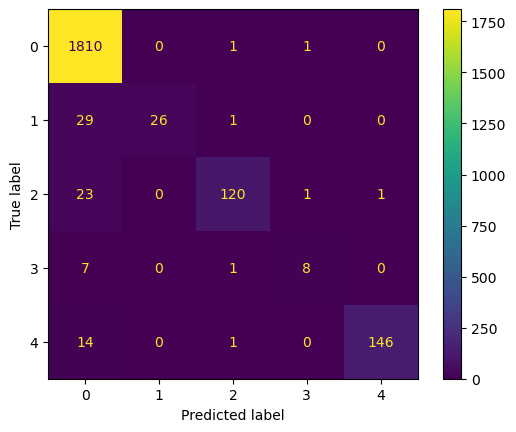

In [56]:
make_confusion_matrix(rf_filtered, X_test_filtered, y_test)

For balanced dataset

In [58]:
rf_balanced = train_model(RandomForestClassifier(random_state=42),
                      X_train_balanced, y_train_balanced, "random", "rf_balanced",
                      param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_balanced, "rf_balanced", X_test_balanced, y_test_balanced)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 32}


Macro F1 Score = 0.8919698803754257


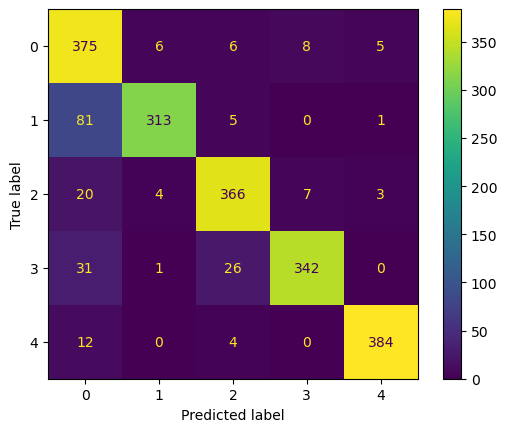

In [59]:
make_confusion_matrix(rf_balanced, X_test_balanced, y_test_balanced)

In [60]:
rf_balanced_filtered = train_model(RandomForestClassifier(random_state=42),
                          X_train_balanced_filtered, y_train_balanced, "random", "rf_balanced_filtered",
                          param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_balanced_filtered, "rf_balanced_filtered",
                                           X_test_balanced_filtered, y_test_balanced)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 32}


Macro F1 Score = 0.8830723364352961


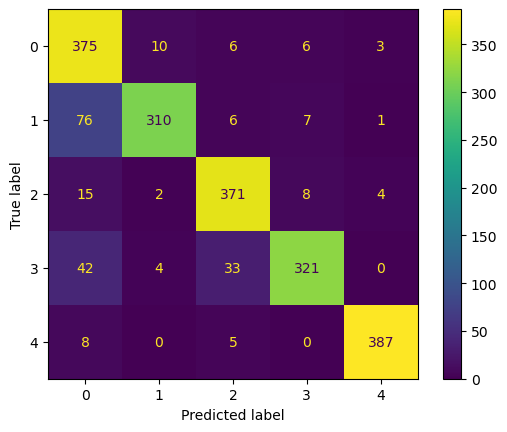

In [61]:
make_confusion_matrix(rf_balanced_filtered, X_test_balanced_filtered, y_test_balanced)

### Gradient Boosting
Next, we will be using Gradient Boosting.

Like before, first we fit a gradient boosting model to the full dataset, doing a random search with 5-fold cross validation over several hyper parameters.

In [62]:
gb_params = dict(n_estimators = [10*i for i in range(1, 11)],
                 max_depth = [1, 2, 3, 4, 5]+[None],
                 min_samples_split = [i+1 for i in range(1, 10)],
                 min_samples_leaf = [i for i in range(1, 10)],
                 learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5])

gb_full = train_model(GradientBoostingClassifier(),
                      X_train, y_train, "random", "gb_full",
                      param_distributions=gb_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=100)

model_summary_df = add_to_model_summary_df(model_summary_df, gb_full, "gb_full", X_test, y_test)

Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_depth': None, 'learning_rate': 0.1}


Macro F1 Score = 0.8370402471415372


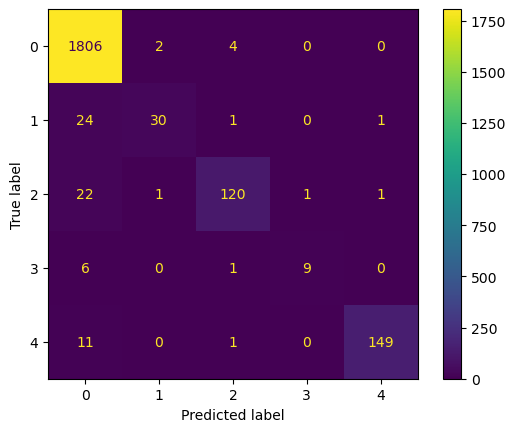

In [63]:
make_confusion_matrix(gb_full, X_test, y_test)

Now we perform the same procedure to fit a gradient boosting model to the filtered training dataset.

In [64]:
gb_filtered = train_model(GradientBoostingClassifier(),
                      X_train_filtered, y_train, "random", "gb_filtered",
                      param_distributions=gb_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=100)

model_summary_df = add_to_model_summary_df(model_summary_df, gb_filtered, "gb_filtered", X_test_filtered, y_test)

Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_depth': None, 'learning_rate': 0.1}


Macro F1 Score = 0.8171827171996011


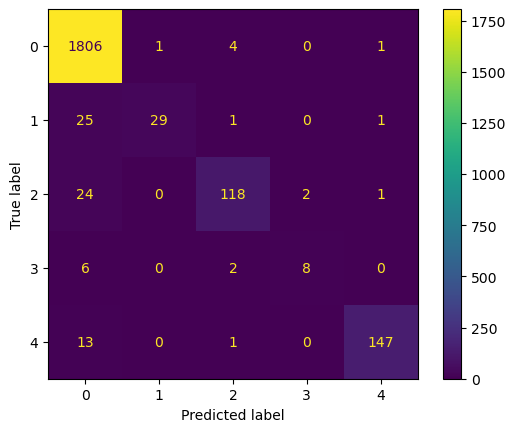

In [65]:
make_confusion_matrix(gb_filtered, X_test_filtered, y_test)

For balanced dataset

In [66]:
gb_balanced = train_model(GradientBoostingClassifier(),
                      X_train_balanced, y_train_balanced, "random", "gb_balanced",
                      param_distributions=gb_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=100)

model_summary_df = add_to_model_summary_df(model_summary_df, gb_balanced, "gb_balanced", X_test_balanced, y_test_balanced)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Model Parameters
{'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': None, 'learning_rate': 0.4}


Macro F1 Score = 0.8916728764602689


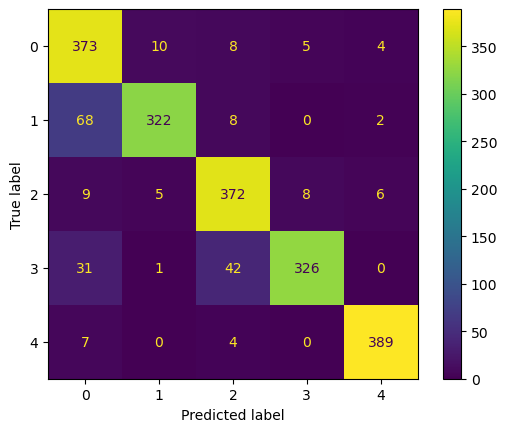

In [67]:
make_confusion_matrix(gb_balanced, X_test_balanced, y_test_balanced)

In [70]:
gb_balanced_filtered = train_model(GradientBoostingClassifier(),
                      X_train_balanced_filtered, y_train_balanced, "random", "gb_balanced_filtered",
                      param_distributions=gb_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=100)

model_summary_df = add_to_model_summary_df(model_summary_df, gb_balanced_filtered, "gb_balanced_filtered",
                                           X_test_balanced_filtered, y_test_balanced)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': None, 'learning_rate': 0.4}


Macro F1 Score = 0.9009065220095656


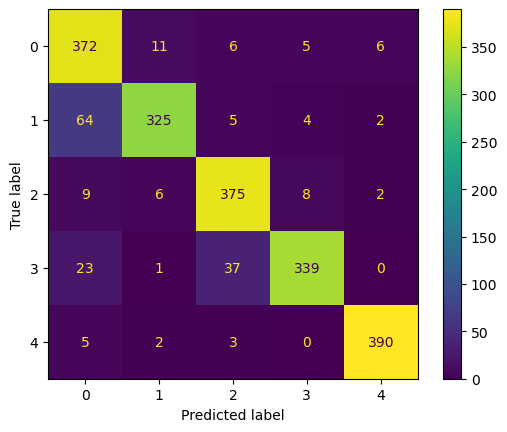

In [71]:
make_confusion_matrix(gb_balanced_filtered, X_test_balanced_filtered, y_test_balanced)

### SVM
Lastly, we will be using support vector machine. Like previous models, we will first fit the full sampled dataset, doing a random search with 5-fold cross validation over several hyper parameters. Several different kernels are tested out. Additionally the `class_weight` parameter is meant to account for imbalanced datasets, which this ECG dataset is, is also included in the grid search.

In [73]:
svc_params = dict(C=np.logspace(-7, 7, 15, base=2),
                  gamma=np.logspace(-7, 7, 15, base=2),
                  kernel=["linear", "poly", "rbf", "sigmoid"],
                  class_weight=["balanced", None])

svc_full = train_model(SVC(), X_train, y_train, "random", "svc_full",
                       param_distributions=svc_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=200)

model_summary_df = add_to_model_summary_df(model_summary_df, svc_full, "svc_full", X_test, y_test)

Best Model Parameters
{'kernel': 'rbf', 'gamma': 0.25, 'class_weight': 'balanced', 'C': 16.0}


Macro F1 Score = 0.8161150080291348


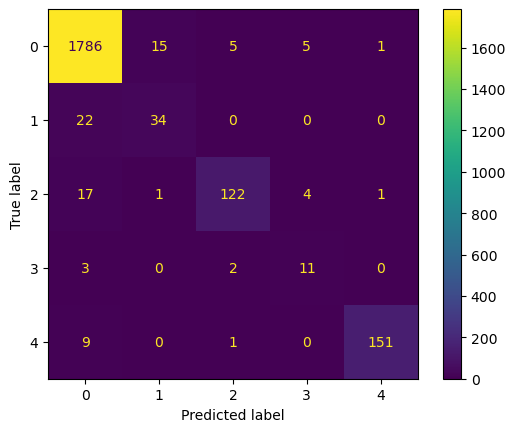

In [74]:
make_confusion_matrix(svc_full, X_test, y_test)

Now perform the same procedure to fit a support vector machine model to the filtered training dataset.

In [75]:
svc_filtered = train_model(SVC(), X_train_filtered, y_train, "random", "svc_filtered",
                           param_distributions=svc_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=200)

model_summary_df = add_to_model_summary_df(model_summary_df, svc_filtered, "svc_filtered", X_test_filtered, y_test)

Best Model Parameters
{'kernel': 'rbf', 'gamma': 0.5, 'class_weight': None, 'C': 32.0}


Macro F1 Score = 0.8438338420066517


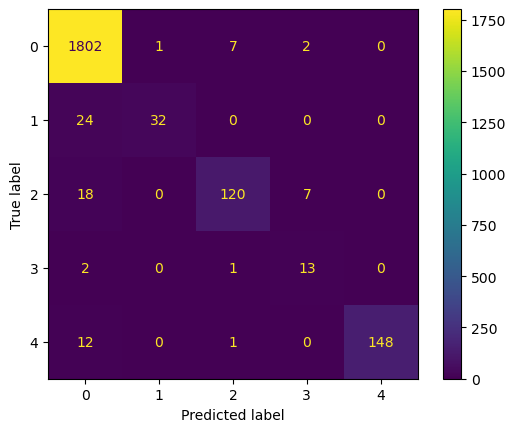

In [76]:
make_confusion_matrix(svc_filtered, X_test_filtered, y_test)

For balanced dataset

In [77]:
svc_balanced = train_model(SVC(), X_train_balanced, y_train_balanced, "random", "svc_balanced",
                       param_distributions=svc_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=200)

model_summary_df = add_to_model_summary_df(model_summary_df, svc_balanced, "svc_balanced", X_test_balanced, y_test_balanced)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Model Parameters
{'kernel': 'rbf', 'gamma': 0.25, 'class_weight': None, 'C': 64.0}


Macro F1 Score = 0.8998173389053491


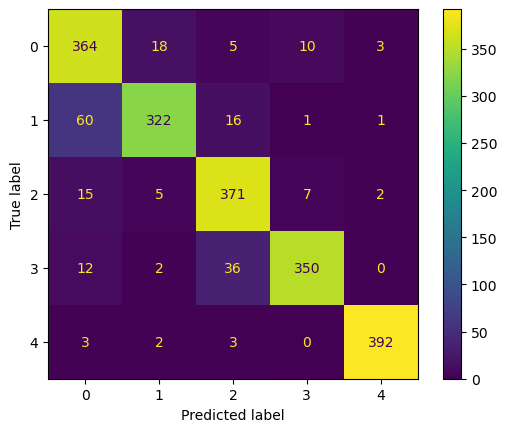

In [78]:
make_confusion_matrix(svc_balanced, X_test_balanced, y_test_balanced)

In [79]:
svc_balanced_filtered = train_model(SVC(), X_train_balanced_filtered, y_train_balanced, "random", "svc_balanced_filtered",
                           param_distributions=svc_params, n_jobs=8, scoring=scorer, verbose=1, n_iter=200)

model_summary_df = add_to_model_summary_df(model_summary_df, svc_balanced_filtered, "svc_balanced_filtered",
                                           X_test_balanced_filtered, y_test_balanced)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Model Parameters
{'kernel': 'rbf', 'gamma': 2.0, 'class_weight': None, 'C': 128.0}


Macro F1 Score = 0.9130726166660696


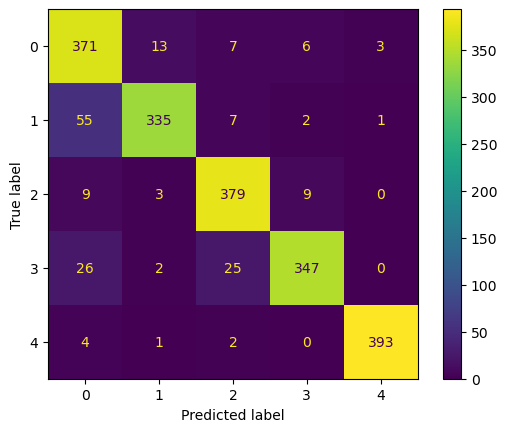

In [80]:
make_confusion_matrix(svc_balanced_filtered, X_test_balanced_filtered, y_test_balanced)

## Evaluation

Throughout all of the above model trainings, a model summary data frame has been built up with how each model performs according to various metrics on the test dataset. The metrics used are:

-   Accuracy: The proportion of cases that were classified correctly.
-   Precision: The proportion of instances correctly classified as a specific class out of all instances classified as that class. Averaged over all classes
-   Recall: The proportion of instances that were correctly classified as a specific class, out of all the instances that actually belong to that class. Averaged over all the classes
-   Macro F1: The harmonic mean of precision and recall, a way of combining them both into a single metric.
-   Train Time: The amount of time it took the model to train

In [81]:
model_summary_df

,Name,Accuracy,Precision,Recall,Macro F1,Train Time
0,knn_full,0.952055,0.852644,0.754618,0.798435,0.091000
1,knn_filtered,0.965753,0.872084,0.820137,0.841271,0.036394
2,knn_balanced,0.871000,0.875999,0.871000,0.871426,0.090202
3,knn_balanced_filtered,0.879500,0.885530,0.879500,0.879820,0.025444
4,rf_full,0.961644,0.942396,0.723668,0.802802,523.549281
5,rf_filtered,0.963470,0.944434,0.739520,0.813896,419.185570
6,rf_balanced,0.890000,0.904588,0.890000,0.891970,373.580259
7,rf_balanced_filtered,0.882000,0.895449,0.882000,0.883072,293.892106
8,gb_full,0.965297,0.941404,0.769591,0.837040,21822.151759
9,gb_filtered,0.962557,0.929378,0.748276,0.817183,6858.801283


Let us use bar chart to visualise the metrics clearer

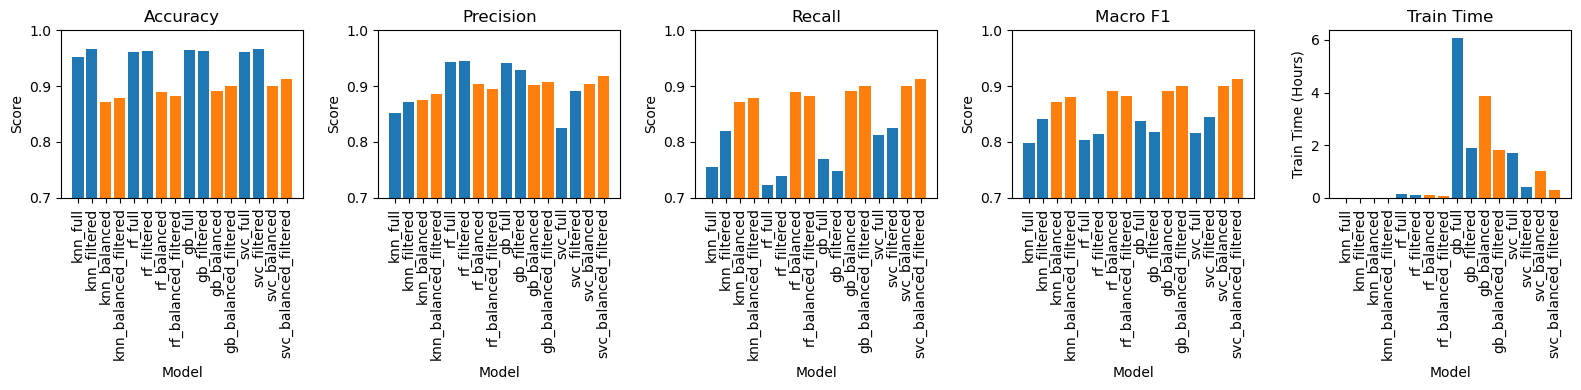

In [90]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
metrics = ["Accuracy", "Precision", "Recall", "Macro F1"]

for i, metric in enumerate(metrics):
    axs[i].bar(model_summary_df["Name"], model_summary_df[metric],color=['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e'])
    axs[i].set_title(metric)
    axs[i].set_xlabel("Model")
    axs[i].set_ylabel("Score")
    axs[i].set_ylim(0.7, 1.0)
    axs[i].tick_params(axis='x', rotation=90)
    
axs[4].bar(model_summary_df["Name"], model_summary_df["Train Time"]/3600,color=['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e'])
axs[4].set_title("Train Time")
axs[4].set_xlabel("Model")
axs[4].set_ylabel("Train Time (Hours)")
axs[4].tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()

Interesting observation about each metric:

-   Accuracy: Models trained with imbalanced dataset clearly performs better on this metric than those trained with balanced dataset. However, this is not unexpected and is not indicative of good performance. Depending of the data used for training, a model can become biased towards certain predictions that result in a high percentage of accurate predictions but poor overall performance. A model might report having very accurate predictions but, in reality, that accuracy might only be a reflection of the way it learned to predict when trained on an imbalanced dataset.


-   Precision and Recall: Here we see that the models trained with imbalanced dataset performs better on precision metric than those trained with balanced dataset. However, models trained with balanced dataset significantly outperforms those trained with imbalanced dataset. Random Forest Models trained with imbalanced dataset performed best in precision but worst in recall. This means that they led to a low amount of false positives but a large amount of false negatives. In the case of balanced dataset, SVC performs the best on both metric with Gradient Boost coming close. Interestingly, in general the filtered dataset performs better.


-   Macro F1: Combining precision and recall together into the Macro F1 score shows that on average, most of the models are preforming very similarly. The significant difference we see here is that models trained with balanced dataset vastly outperforms models trained with imbalanced dataset. 


-   Train Times: It is clear that models trained on balanced dataset finishes training faster than those with imbalanced dataset. The KNN models trained almost instantly. The Random Forest Models finished in under 10 minutes which is relatively fast. The Gradient Boosting model on the full dataset took the longest to train, with the gradient boosting model on the filtered dataset taking under half that time. This illustrates that gradient boosting models train very slowly compared to other models. Finally the SVC model trained on the full dataset took less than half the time to train Gradient Boosting model. Interestingly, reducing the number of features significantly shorten the training time. 

Additionally, the filtered version of the model generally performed better, meaning that the random forest based feature selection was a valid way to improve the models.

It would appear based on all of these metrics the the Support Vector Classifier trained on the balanced filtered dataset is the clear winner. It has the best recall and macro f1 scores as well as reasonable train time. For classifying heartbeats it makes sense to prioritize avoiding false negatives rather than false positives, although ideally both should be avoided. A false negative potentially means that the algorithm missed identifying a dangerous arrhythmia which could be life threatening while a false positive means the algorithm mislabeled a heartbeat as arrhythmia which, especially if looked at by a medical professional, would likely be caught quickly. Therefore recall should be prioritized over precision as a high recall minimizes false negatives.

## Discussion

The end goal of this project was to be able to build a machine learning model that is able to classify heartbeats represented by ECG time series data as either normal or as one of four different type of arrhythmia. The procedure followed was:

1.  Sample the data, here we performed stratified sampling and weighted sampling
2.  Explore and understand the data with exploratory data analysis
3.  Use a clustering algorithm on summary statistics of the time series to perform outlier detection and removal
4.  Train a random forest on the data and use it to extract feature importance to be used for feature selection
5.  Train two different types of machine learning algorithm on each of the training data: K Nearest Neighbors, Random Forest, Gradient Boosted Classifier, and a Support Vector Classifier.
    -   For each classifier type four models were trained.
    -   For models with a low numbers of hyperparameters (K Nearest Neighbors), a grid search was done to find the hyperparameters that perform best
    -   For models with a high number of hyperparameters (The rest of them), a grid search would have been very computationally expensive, so a random search over the hyperparameter space was done instead.
    -   For both grid search and random search, the models were evaluated using five fold cross validation to help ensure generalizability
    -   The Macro F1 score was used as a scoring metric in the hyperparameter searches, as it provides a good evaluation of the performance of unbalanced datasets
5.  After training all models, the model that performed the best was the Support Vector Classifier trained with balanced dataset using feature selection.

However, one should note that accuracy rate of 91.25% is not good enough for medical use. This would mean that on average 9 out of every 100 heartbeats would be misclassified and this can be fatal. In order to be practical to use, the model would need to achieve even higher accuracy. Below are some ideas for potential ways to improve the model if it were to be iterated on:

-   Train on larger dataset, possibly the entire available dataset: For computation reasons, we only took a sample of the dataset, however using all of that data would likely train a better model.
-   Do more through hyper parameter searches: Again for computational reasons, only a random search was done for three of the model types, meaning only a small subset of the possible hyper parameter were checked. Given more time or a faster computer a larger random search or even a full grid search could have been done to find better hyper parameters
-   Better feature importance cutoff: The analysis showed that all models where feature selection was done performed better across all metrics that models where it wasn't. The feature importance cutoff of 0.005 was chosen somewhat arbitrarily based on visual inspection of a plot. If this number was tuned along with other hyper parameters when training models, perhaps a better value could have been found.
-   Calculate new features: Only the raw time series points along with their mean and standard deviation were used as features for this classification. Additional features could have been calculated and added to the datasets that could have lead to better models. Some ideas for new features:
    -   Frequency domain coefficients calculated with Fourier or wavelet analysis of the time series data.
    -   Medically informed statistics like the intervals of the various parts of the ECG wave such as the PR Interval or the QRS Complex

## Bibliography:

[1] *ECG Heartbeat Categorization Dataset*. (n.d.). Www.kaggle.com. https://www.kaggle.com/datasets/shayanfazeli/heartbeat

[2] Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215--e220.

[3] *PTB Diagnostic ECG Database v1.0.0*. (n.d.). Www.physionet.org. https://www.physionet.org/content/ptbdb/1.0.0/

‌[4] Mayo Clinic. (2019, March 19). *Electrocardiogram (ECG or EKG) - Mayo Clinic*. Mayoclinic.org; Mayo Clinic. https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983